### Rohan Sanda 2023 ###

### Preliminary Patient Demographic and Post Processing PPG signal quality analysis ###

In [2]:
import vitaldb
import numpy as np
import pandas as pd
import scipy.signal as ss
from scipy.ndimage import minimum_filter1d, maximum_filter1d
from scipy.stats import median_absolute_deviation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
import json
import sys
from tqdm.auto import tqdm


# colorblind friendly palette
import matplotlib as mpl
cp = ["#172A5A", "#FF7171", "#227567", "#34BAEA", "#F9D466", ]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=cp)

# set default font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Open Sans', 'Arial']
plt.rcParams['figure.figsize'] = [10, 5]
from scipy.stats import norm


In [10]:
with open('test1_segments.pickle', 'rb') as f:
    segments = pickle.load(f)

In [16]:
with open('test3_flat_bps.pickle', 'rb') as f:
    bps = pickle.load(f)

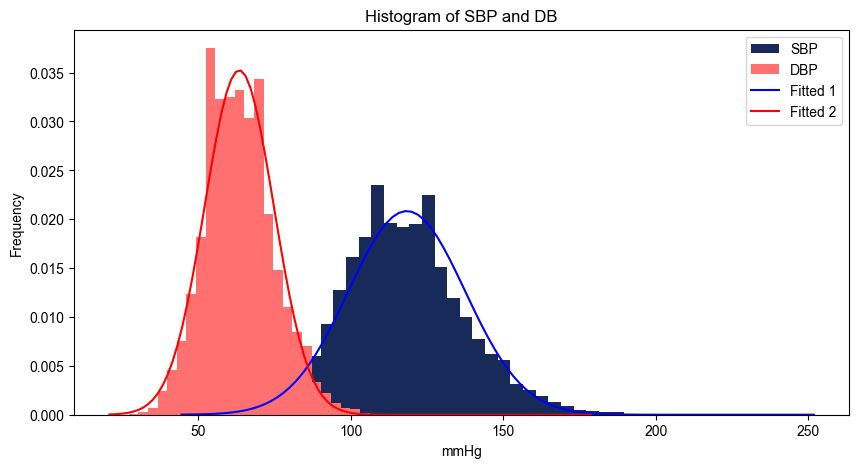

Mean SBP: 118.35182062777925 +- 19.145081150634496 Mean DBP: 63.40524003314699 +- 11.317355836398905


In [31]:
sbp = bps[:, 0]
sbp=sbp[np.isfinite(sbp)]
sbp_mean = np.mean(sbp)
sbp_std = np.std(sbp)
dbp = bps[:, 1]
dbp=dbp[np.isfinite(dbp)]
dbp_mean = np.mean(dbp)
dbp_std = np.std(dbp)

# Fit a normal distribution to the data
x1 = np.linspace(min(sbp), max(sbp), 100)
mu1, std1 = norm.fit(sbp)
y1 = norm.pdf(x1, mu1, std1)

x2 = np.linspace(min(dbp), max(dbp), 100)
mu2, std2 = norm.fit(dbp)
y2 = norm.pdf(x2, mu2, std2)

# Plot the histogram
plt.hist(sbp, bins=50, label='SBP', density=True)
plt.hist(dbp, bins=50, label='DBP', density=True)
# Plot the fitted curves
plt.plot(x1, y1, 'b-', label='Fitted 1')
plt.plot(x2, y2, 'r-', label='Fitted 2')
# Add a legend
plt.legend()
plt.xlabel('mmHg')
plt.ylabel('Frequency')
plt.title('Histogram of SBP and DB')
plt.legend()
plt.show()

print(f"Mean SBP: {sbp_mean} +- {sbp_std} Mean DBP: {dbp_mean} +- {dbp_std}")

In [39]:
with open('test2_pulse_lengths.pickle', 'rb') as f:
    lens = pickle.load(f)

In [42]:
# Find number of elements in lens greater than 200
num_long = sum([1 for x in lens if x > 200])

In [43]:
print(num_long)

203


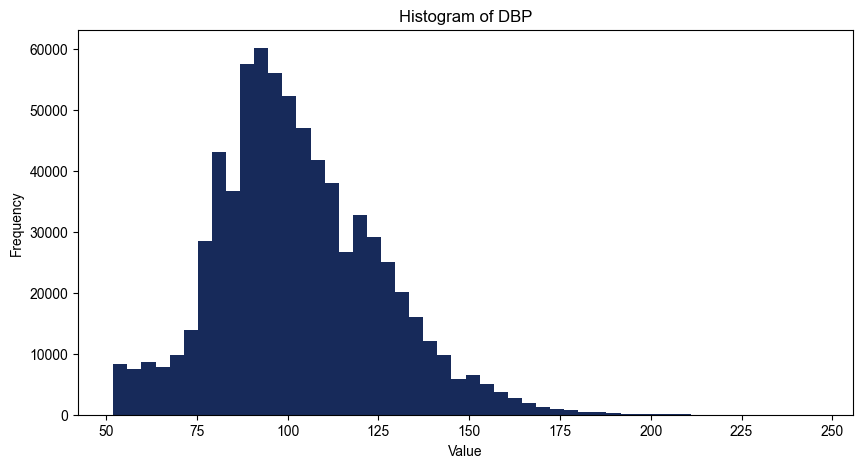

In [41]:
plt.hist(lens, bins=50)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of DBP')
plt.show()

In [36]:
n_nans = np.sum(np.isnan(segments))

In [37]:
n_nans

0

In [11]:
with open('test1_bps.pickle', 'rb') as f:
    bps_mat = pickle.load(f)

In [8]:
with open('final_caseids.pickle', 'rb') as f:
    caseids = pickle.load(f)

In [3]:
type(segments)

numpy.ndarray

In [13]:
np.shape(segments)
np.shape(bps_mat)

(3854999, 2)

In [20]:
sig = segments[10000, :]

In [29]:
from scipy.interpolate import interp1d


In [33]:
t = np.linspace(0, 1, 200)


# Create a higher-resolution time vector
t_new = np.linspace(0, 1, 1000)

# Use linear interpolation to upsample the signal
f = interp1d(t, sig, kind='linear')
y_new = f(t_new)


# take the first derivative
dy_dt = np.gradient(y_new, t_new)

# take the second derivative
d2y_dt2 = np.gradient(dy_dt, t_new)

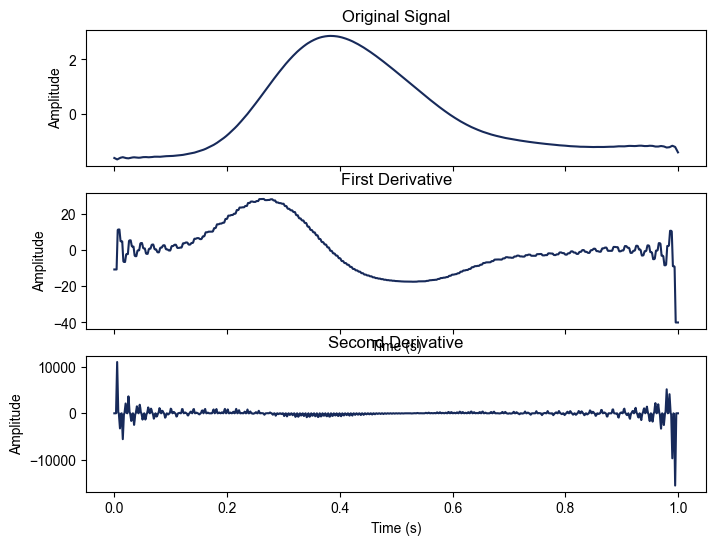

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(8, 6))

ax1.plot(t_new, y_new)
ax1.set_ylabel('Amplitude')
ax1.set_title('Original Signal')

ax2.plot(t_new, dy_dt)
ax2.set_ylabel('Amplitude')
ax2.set_xlabel('Time (s)')
ax2.set_title('First Derivative')

ax3.plot(t_new, d2y_dt2)
ax3.set_ylabel('Amplitude')
ax3.set_xlabel('Time (s)')
ax3.set_title('Second Derivative')

plt.show()


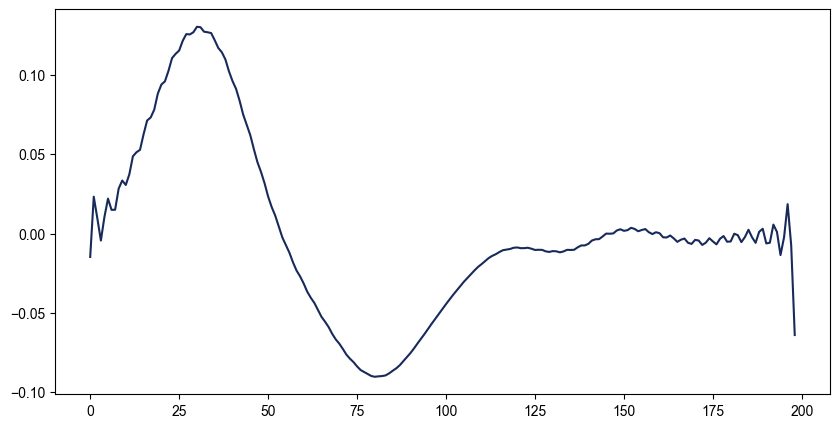

In [19]:
deriv1 = np.diff(segments[1000, :])
plt.plot(deriv1)

In [3]:
with open('test3_flat_caseids.pickle', 'rb') as f:
    caseids = pickle.load(f)

In [4]:
np.shape(caseids)

(718035,)

In [5]:
unique = np.unique(caseids)

In [9]:

import pandas as pd
df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # clinical information
df_trks = pd.read_csv("https://api.vitaldb.net/trks")  # track list
df_labs = pd.read_csv('https://api.vitaldb.net/labs')  # laboratory results

In [12]:
df_cases.head()

,caseid,subjectid,casestart,caseend,anestart,aneend,opstart,opend,adm,dis,...,intraop_colloid,intraop_ppf,intraop_mdz,intraop_ftn,intraop_rocu,intraop_vecu,intraop_eph,intraop_phe,intraop_epi,intraop_ca
0,1,5955,0,11542,-552,10848.0,1668,10368,-236220,627780,...,0,120,0.0,100,70,0,10,0,0,0
1,2,2487,0,15741,-1039,14921.0,1721,14621,-221160,1506840,...,0,150,0.0,0,100,0,20,0,0,0
2,3,2861,0,4394,-590,4210.0,1090,3010,-218640,40560,...,0,0,0.0,0,50,0,0,0,0,0
3,4,1903,0,20990,-778,20222.0,2522,17822,-201120,576480,...,0,80,0.0,100,100,0,50,0,0,0
4,5,4416,0,21531,-1009,22391.0,2591,20291,-67560,3734040,...,0,0,0.0,0,160,0,10,900,0,2100


In [14]:
filtered_df = df_cases[df_cases['caseid'].isin(unique)]
cols = ["caseid", "sex", "age", "bmi"]
filtered_df = filtered_df[cols]
filtered_df

,caseid,sex,age,bmi
0,1,M,77.0,26.3
3,4,M,74.0,20.5
6,7,F,52.0,22.2
9,10,M,72.0,23.8
15,16,M,57.0,26.2
...,...,...,...,...
885,886,F,67.0,25.3
893,894,F,60.0,26.0
906,907,M,64.0,25.3
916,917,M,74.0,19.6


In [15]:
# Compute the average age, percentage of M and F, and average BMI
gender_counts = filtered_df['sex'].value_counts()
total_count = len(filtered_df)
proportion_male = gender_counts['M'] / total_count
proportion_female = gender_counts['F'] / total_count
avg_bmi = filtered_df['bmi'].mean()

print("Average age: ", filtered_df['age'].mean())
print("Proportion Males: ", proportion_male)
print("Proportion Female: ", proportion_female)
print("Average BMI: ", avg_bmi)

Average age:  59.97810218978102
Proportion Males:  0.5948905109489051
Proportion Female:  0.4051094890510949
Average BMI:  22.909854014598537
